## Load the Haystack pipeline from Amazon S3 and run inferences - Part 2
---

In this notebook, we will we load the haystack pipeline that is stored in S3 as a `yml` file. Once the haystack pipeline is loaded, we will run a series of questions against the pipeline and measure different metrics, such as latency, accuracy metrics, etc. 

In [1]:
# import libraries
import os
import json
import boto3
import pickle
import logging
import tempfile
import pandas as pd
import globals as g
from typing import List

In [2]:
!pip install -Uq haystack

In [3]:
# Set a logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

Now, we will load the pipeline from the s3 bucket where it was saved as a `yml` file, and then see the contents of the pipeline. We will then run a series of inference requests against the pipeline and measure latency and accuracy metrics

In [4]:
# Initialize the S3 client
s3_client = boto3.client('s3')

# Create temporary file and download pipeline
with tempfile.NamedTemporaryFile(mode='wb', suffix='.yml', delete=False) as tmp_file:
    # Download from the same location where we uploaded
    s3_client.download_fileobj(
        g.HAYSTACK_PIPELINE_BUCKET, 
        g.HAYSTACK_PIPELINE_KEY, 
        tmp_file
    )
    logger.info(f"Downloaded the haystack pipeline from {g.HAYSTACK_PIPELINE_BUCKET}/{g.HAYSTACK_PIPELINE_KEY} to {tmp_file.name}")
    tmp_file_path = tmp_file.name

[2024-11-14 18:09:33,153] p26831 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials
[2024-11-14 18:09:33,872] p26831 {2606389201.py:12} INFO - Downloaded the haystack pipeline from sagemaker-us-east-2-015469603702/pipelines/basic_rag_pipeline.yml to /var/folders/jy/g9mb5j5n6c11fgdj788p5rww0000gr/T/tmpzn55ncau.yml


In [5]:
# Download and load document store
doc_store_key = "pipelines/document_store/documents.json"
with tempfile.NamedTemporaryFile(mode='wb', suffix='.pkl', delete=False) as tmp_file:
    s3_client.download_fileobj(
        g.HAYSTACK_PIPELINE_BUCKET, 
        doc_store_key, 
        tmp_file
    )
    print(f"Downloaded the document store from {g.HAYSTACK_PIPELINE_BUCKET}/{doc_store_key} to {tmp_file.name}")
    docstore_tmp_path = tmp_file.name

Downloaded the document store from sagemaker-us-east-2-015469603702/pipelines/document_store/documents.json to /var/folders/jy/g9mb5j5n6c11fgdj788p5rww0000gr/T/tmptwu0ryjd.pkl


In [7]:
from haystack import Pipeline
# Now we will load the pipeline from the temporary file path
with open(tmp_file_path, 'r') as file:
    loaded_pipeline = Pipeline.load(file)
    print(f"Loaded the haystack pipeline from {tmp_file_path}")

[2024-11-14 18:11:31,564] p26831 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


Loaded the haystack pipeline from /var/folders/jy/g9mb5j5n6c11fgdj788p5rww0000gr/T/tmpzn55ncau.yml


[2024-11-14 18:11:32,936] p26831 {1922383777.py:4} INFO - Loaded Pipeline Structure:


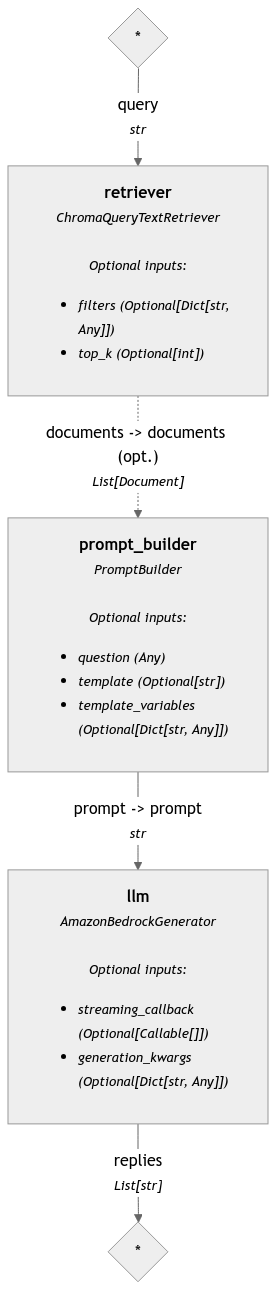

In [8]:
# Now we will clean up the temporary file path and then see the contents of the pipeline
# that we had saved to s3
os.remove(tmp_file_path)
logger.info("Loaded Pipeline Structure:")
loaded_pipeline.show()

In [9]:
# load the documents stored earlier and get those documents in the doc store
import json
from haystack_integrations.document_stores.chroma import ChromaDocumentStore

# Load the documents from the JSON file
with open(docstore_tmp_path, 'r') as f:
    documents_dicts = json.load(f)

from haystack import Document
import numpy as np

# Convert embeddings back to NumPy arrays
for doc_dict in documents_dicts:
    if 'embedding' in doc_dict and isinstance(doc_dict['embedding'], list):
        doc_dict['embedding'] = np.array(doc_dict['embedding'])

# Reconstruct Document objects
documents = [Document.from_dict(doc_dict) for doc_dict in documents_dicts]
document_store = ChromaDocumentStore()
# Write the documents to the document store
document_store.write_documents(documents)


[2024-11-14 18:11:35,491] p26831 {posthog.py:22} INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


1000

In [10]:
# Integrate the document store into your pipeline
retriever = loaded_pipeline.get_component('retriever')
retriever.document_store = document_store

### Run inferences against the haystack pipeline using Amazon Bedrock
---

Now that we have loaded the pipeline from `s3`, we can run some inferences against this RAG pipeline. As we run inferences, we will measure latency and semantic similarity using the `SASEvaluator` module from haystack.

In [11]:
# Load the dataset that we processed in the first notebook
df = pd.read_csv(os.path.join(g.DATA_DIR, g.PUBMED_QA_CSV_FNAME)) 

# We will select the first 10 rows of the dataset for testing
test_data = df.head(20)
test_data

,instruction,context,response,category
0,Do cC and CXC chemokine levels in children wit...,Chemokines are a superfamily of small peptides...,Initial-phase serum levels of chemokines in pa...,closed_qa
1,Are sAH gene variants associated with obesity-...,The SAH gene locus has recently been proposed ...,We confirm recent evidence that the SAH locus ...,closed_qa
2,Do the functional anatomy of gaze-evoked tinni...,To identify neural sites associated with gaze-...,Patients with GET have plastic changes in mult...,closed_qa
3,Does neighborhood fast-food outlet exposure am...,Greater exposures to fast-food outlets and low...,These findings suggest that efforts to improve...,closed_qa
4,Does conditioned pain modulation predict exerc...,Conditioned pain modulation (CPM) is the conce...,"CPM was attenuated in older adults, as measure...",closed_qa
5,Does notch-1 promote breast cancer cells proli...,Notch signaling is indicated as novel therapeu...,Notch-1 promotes breast cancer cells prolifera...,closed_qa
6,Chronic osteomyelitis in childhood: is surgery...,"Presently, most children with chronic osteomye...",Our diagnostic procedure was useful to reduce ...,closed_qa
7,Does exercise protect against articular cartil...,It has been reported that osteoarthritis can o...,A sedentary lifestyle in the hamster leads to ...,closed_qa
8,Does bisoprolol/amlodipine combination therapy...,The efficacy of a bisoprolol/amlodipine fixed-...,Bisoprolol/amlodipine FDC therapy is associate...,closed_qa
9,Does global DNA hypomethylation occur in the e...,Global DNA hypomethylation has been found in t...,Global DNA hypomethylation occurs in the early...,closed_qa


In [12]:
question: str = "What is a neurodegenerative disease? Give me examples"
document_store = loaded_pipeline.get_component('retriever')
# Directly query the document store to simulate what the BM25 retriever would retrieve
retrieved_docs = document_store.run(question)  # Use the question as the query

# Print the retrieved documents' content or metadata
print(f"Retrieved Documents: {retrieved_docs}")

# Now proceed with the full pipeline run to generate the final response
response = loaded_pipeline.run({
    "retriever": {"query": question},
    "prompt_builder": {"question": question}
})
print("LLM Response:")
print(response["llm"]["replies"][0])


[2024-11-14 18:13:03,186] p26831 {pipeline.py:75} INFO - Running component retriever
[2024-11-14 18:13:03,283] p26831 {pipeline.py:75} INFO - Running component prompt_builder
[2024-11-14 18:13:03,283] p26831 {pipeline.py:75} INFO - Running component llm


Retrieved Documents: {'documents': [Document(id=853c62d5179c603ed71a3c85e58728c00d2901592cef2e18f38d41ff50694817, content: 'Instruction: Is memory performance related to amyloid and tau pathology in the hippocampus?
Context:...', meta: {'category': 'closed_qa', 'question': 'Is memory performance related to amyloid and tau pathology in the hippocampus?'}, score: 1.1025115251541138, embedding: vector of size 384), Document(id=b9d7380f5363480e9901ff01cf72bc3e2024711c9c577f7ef3a7de63431739ef, content: 'Instruction: Do mutations for Gaucher disease confer high susceptibility to Parkinson disease?
Conte...', meta: {'category': 'closed_qa', 'question': 'Do mutations for Gaucher disease confer high susceptibility to Parkinson disease?'}, score: 1.276674509048462, embedding: vector of size 384), Document(id=077badf8cfaadbee729b985913d9ee9b7db100290a09374db39d684ccc861e61, content: 'Instruction: Is anosmia very common in the Lewy body variant of Alzheimer 's disease?
Context: Olfac...', meta: {'

### Measure the `SASEvaluation` score

Now, we will use Haystack's `SAS evaluator` to generate answers to the first 20 questions of the dataset. `SASEvaluator` will evaluate the answer predicted my the pipeline that we have loaded and then compare the semantic similarity to the ground truth provided in the dataset.

In [14]:
from haystack.components.evaluators import SASEvaluator

# Extract the questions and ground truth answers
test_queries = test_data['instruction'].tolist()
ground_truth_answers = test_data['response'].tolist()

# Initialize the SAS evaluator
sas_evaluator = SASEvaluator()
sas_evaluator.warm_up()

# Running the pipeline to get predictions
results = []
for question in test_queries:
    # Run the pipeline to get the predicted answer
    response = loaded_pipeline.run({
        "retriever": {"query": question},
        "prompt_builder": {"question": question}
    })
    predicted_answer = response["llm"]["replies"][0]
    results.append(predicted_answer)

# Evaluate the results using SAS evaluator
sas_evaluation = sas_evaluator.run(ground_truth_answers=ground_truth_answers, predicted_answers=results)

# Print the evaluation results
print("Semantic Answer Similarity Evaluation:")
print("Individual scores:", sas_evaluation["individual_scores"])
print("Overall mean SAS score:", sas_evaluation["score"])

# Optionally, print detailed results
print("\nDetailed Results:")
for i, (query, ground_truth, predicted) in enumerate(zip(test_queries, ground_truth_answers, results)):
    print(f"\nQuery {i+1}: {query}")
    print(f"Ground Truth: {ground_truth}")
    print(f"Predicted: {predicted}")
    print(f"SAS Score: {sas_evaluation['individual_scores'][i]}")


[2024-11-14 18:13:29,622] p26831 {SentenceTransformer.py:218} INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
[2024-11-14 18:13:33,723] p26831 {pipeline.py:75} INFO - Running component retriever
[2024-11-14 18:13:34,003] p26831 {pipeline.py:75} INFO - Running component prompt_builder
[2024-11-14 18:13:34,004] p26831 {pipeline.py:75} INFO - Running component llm
[2024-11-14 18:13:35,894] p26831 {pipeline.py:75} INFO - Running component retriever
[2024-11-14 18:13:35,998] p26831 {pipeline.py:75} INFO - Running component prompt_builder
[2024-11-14 18:13:35,998] p26831 {pipeline.py:75} INFO - Running component llm
[2024-11-14 18:13:36,007] p26831 {generator.py:182} WARNING - The prompt was truncated from 4513 tokens to 3996 tokens so that the prompt length and the answer length (100 tokens) fit within the model's max token limit (4096 tokens). Shorten the prompt or it will be cut off.
[2024-11-14 18:13:38,381] p26831 {pipeline.py:75} 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Answer Similarity Evaluation:
Individual scores: [0.8585457801818848, 0.733194887638092, 0.7152416706085205, 0.6956210136413574, 0.3235836923122406, 0.8352118134498596, 0.7314049005508423, 0.2856455445289612, 0.4453977942466736, 0.8785775899887085, 0.2587859332561493, 0.40503907203674316, 0.9113739728927612, 0.8424026966094971, 0.7845391035079956, 0.7799321413040161, 0.7931575775146484, 0.795962929725647, 0.36555683612823486, 0.34527623653411865]
Overall mean SAS score: 0.6392225593328476

Detailed Results:

Query 1: Do cC and CXC chemokine levels in children with meningococcal sepsis accurately predict mortality and disease severity?
Ground Truth: Initial-phase serum levels of chemokines in patients with meningococcal sepsis can predict mortality and can correlate strongly with disease severity. Chemokines may play a key role in the pathophysiology of meningococcal disease and are potentially new targets for therapeutic approaches.
Predicted: Based on the context provided:

Y